<a href="https://colab.research.google.com/github/ClarktheDarkShark/CS3315_Final_Project/blob/main/class-1/class-1-LatentSpacePyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Christopher Clark's noteboook
Homework - Week 1

7 Sept 2025

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

 The `Autoencoder` class inherits from `nn.Module`, a base class for all neural network modules in PyTorch. Here's a breakdown of the code and its functionality:

### Initialization Method (`__init__`)
- **Parameters**: The `__init__` method accepts a single parameter `encoding_dim`, which specifies the size of the latent space where the input data is compressed.
- **Encoder**: The encoder part of the autoencoder is designed to compress the input data (in this case, an image) into a lower-dimensional representation called the latent space. It consists of a sequence of layers:
  - `nn.Linear(28 * 28, 128)`: This layer flattens the input image (assumed to be 28x28 pixels, typical for MNIST dataset images) into a one-dimensional array and performs a linear transformation to reduce its dimension to 128.
  - `nn.ReLU(True)`: A Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity, helping the model learn complex patterns.
  - Another `nn.Linear(128, encoding_dim)`: Further reduces the dimension from 128 to the specified `encoding_dim`.
  - Another `nn.ReLU(True)`: Another ReLU activation for non-linearity.
- **Decoder**: The decoder part reconstructs the original input data from the compressed representation. It mirrors the encoder structure but in reverse, aiming to expand the compressed data back to its original shape:
  - `nn.Linear(encoding_dim, 128)`: Expands the compressed data from `encoding_dim` back to 128.
  - `nn.ReLU(True)`: Applies ReLU activation.
  - `nn.Linear(128, 28 * 28)`: Transforms the data from 128 back to the flattened image size of 784 (28x28).
  - `nn.Sigmoid()`: Applies a sigmoid activation function to ensure the output values are between 0 and 1, suitable for image data where pixel values typically fall within this range.

### Forward Method (`forward`)
- **Parameter**: The `forward` method defines how the input `x` flows through the network.
- **Process**:
  - `x.view(-1, 28*28)`: First, the input `x` is reshaped into a one-dimensional array (flattened) if not already done.
  - `self.encoder(x)`: The flattened `x` is then passed through the encoder.
  - `self.decoder(x)`: The output from the encoder, which is the compressed representation, is fed into the decoder.
- **Output**: The final output is reshaped back to the original image dimensions (`-1, 1, 28, 28`), where `-1` is a placeholder that automatically adjusts based on the batch size.


In [2]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),  # Flatten the image and then linearly transform it
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(256, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),  # Linearly transforms the encoding
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(256, 28 * 28),  # Transforms back to original image shape
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))
        if self.training and 0.2 > 0:            # <- added noisem, but only while training
            x = x + torch.randn_like(x) * 0.2
        x = self.decoder(x)
        return x.view(-1, 1, 28, 28)

In [3]:

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reshape and display the image
    plt.show()

In [4]:
# Transform: converts images to PyTorch tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
import os
import urllib.request
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mnist_dir = "./data/MNIST/raw/"
os.makedirs(mnist_dir, exist_ok=True)

base_url = "https://github.com/nispoe/GWU-SEAS-8525/raw/main/class-1/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

for file in files:
    file_path = os.path.join(mnist_dir, file)
    if not os.path.exists(file_path):
        print(f"Downloading {file}...")
        urllib.request.urlretrieve(base_url + file, file_path)

transform = transforms.Compose([transforms.ToTensor()])

In [6]:
import gzip
import shutil

gz_files = [f for f in os.listdir(mnist_dir) if f.endswith(".gz")]

for file in gz_files:
    gz_path = os.path.join(mnist_dir, file)
    output_path = gz_path.replace(".gz", "")  # Remove .gz extension

    # Extract the file
    with gzip.open(gz_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [7]:
# MNIST dataset loading
from torch.utils.data import random_split

batch_size = 64    # <- add batch_size variable to better maintain across datasets

#train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


# Modified the train_loader and added a val_loader to include a validation set for training
n_val = int(0.1 * len(train_dataset))
train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - n_val, n_val],
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)

# Add test set loader (this was missing and essential)
test_dataset = MNIST(root='./data', train=False, download=False, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)  # <- added this to verify what device I am on

model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer  <- Changed learning rate

Device: cuda


In [9]:
from torch.amp import GradScaler, autocast  # Updated import
from copy import deepcopy

num_epochs = 200
# Correct way to initialize GradScaler
scaler = GradScaler(device="cuda")  # New syntax

best_weights = None
best_val = float("inf")
patience_ctr = 0
early_stop = 5    # <- Implementing early stop manually
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast(device_type="cuda"):  # Updated syntax
            output = model(img)
            loss = criterion(output, img)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * img.size(0)

    train_epoch_loss = running_loss / len(train_loader.dataset)


    # Conduct a validation step to determine generalizability
    model.eval()
    val_running = 0.0
    with torch.no_grad(), autocast(device_type="cuda", enabled=(device.type == "cuda")):
        for img, _ in val_loader:
            img = img.to(device)
            out = model(img)
            vloss = criterion(out, img)
            val_running += vloss.item() * img.size(0)

    val_epoch_loss = val_running / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | train {train_epoch_loss:.4f} | val {val_epoch_loss:.5f}")



    if val_epoch_loss < best_val:
        best_val = val_epoch_loss
        patience_ctr = 0
        best_weights = deepcopy(model.state_dict())
    else:
        patience_ctr += 1
        if patience_ctr >= early_stop:
            print(f"Early stop: no improvement for {early_stop} epochs. Best val={best_val:.4f}")
            break

# restore best weights (if any)
if best_weights is not None:
    model.load_state_dict(best_weights)

Epoch 1/200 | train 0.0335 | val 0.01682
Epoch 2/200 | train 0.0136 | val 0.01144
Epoch 3/200 | train 0.0104 | val 0.00954
Epoch 4/200 | train 0.0089 | val 0.00837
Epoch 5/200 | train 0.0080 | val 0.00762
Epoch 6/200 | train 0.0074 | val 0.00724
Epoch 7/200 | train 0.0070 | val 0.00681
Epoch 8/200 | train 0.0066 | val 0.00648
Epoch 9/200 | train 0.0064 | val 0.00624
Epoch 10/200 | train 0.0062 | val 0.00618
Epoch 11/200 | train 0.0060 | val 0.00610
Epoch 12/200 | train 0.0059 | val 0.00586
Epoch 13/200 | train 0.0057 | val 0.00586
Epoch 14/200 | train 0.0056 | val 0.00570
Epoch 15/200 | train 0.0055 | val 0.00549
Epoch 16/200 | train 0.0055 | val 0.00548
Epoch 17/200 | train 0.0054 | val 0.00545
Epoch 18/200 | train 0.0053 | val 0.00541
Epoch 19/200 | train 0.0053 | val 0.00539
Epoch 20/200 | train 0.0052 | val 0.00530
Epoch 21/200 | train 0.0052 | val 0.00536
Epoch 22/200 | train 0.0051 | val 0.00527
Epoch 23/200 | train 0.0051 | val 0.00519
Epoch 24/200 | train 0.0051 | val 0.00512
E

In [20]:
!pip install torchmetrics

from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

model.eval()
ssim_vals = []
with torch.no_grad():
    for img, _ in test_loader:
        img = img.to(device)
        recon = model(img)
        ssim_vals.append(ssim_metric(recon, img).item())

print(f"Average SSIM: {sum(ssim_vals)/len(ssim_vals):.4f}")


Average SSIM: 0.9586


Original Images


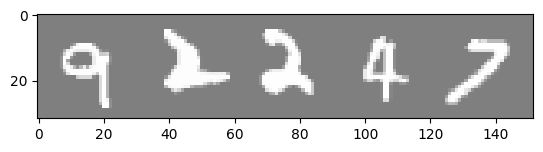

Reconstructed Images


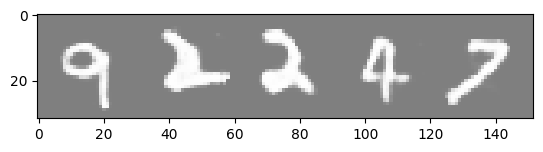

Latent Space (PCA Projection)


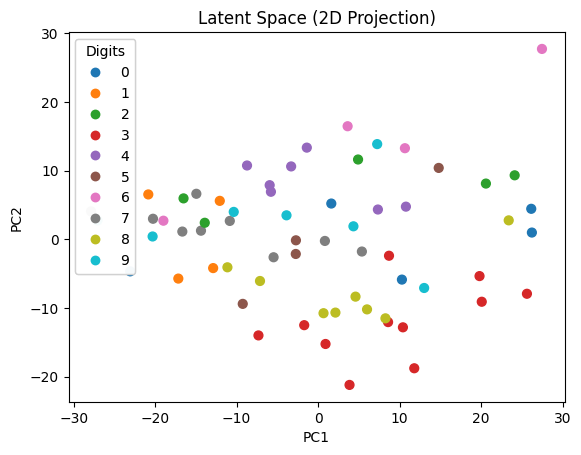

In [24]:
from sklearn.decomposition import PCA

# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.to(device)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:5], normalize=True))

# Encoded and decoded images
with torch.no_grad():
    # encoded_imgs = model.encoder(images.view(-1, 28*28)[:4])
    encoded_imgs = model.encoder(images[:5].view(-1, 28*28))
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)


# Display reconstructed images
print("Reconstructed Images")
imshow(vutils.make_grid(decoded_imgs[:5], normalize=True))

# Below code was not useful (at least for visualization). Added ^^^ above to visualize the generated images
# print("Original Representation")
# print(img)

# Print latent space
# print("Latent space representations:")
# print(encoded_imgs)       # <- Same unuseful representation. Instead, visualize as below
# imshow(vutils.make_grid(encoded_imgs[:5], normalize=True))
# encoded = model.encoder(images.view(-1, 28*28)).detach().cpu()


# Projecting to a 2D space for valuable visualization
print("Latent Space (PCA Projection)")
with torch.no_grad():
    z = model.encoder(images.view(-1, 28*28)).detach().cpu().numpy()
z2 = PCA(n_components=2).fit_transform(z)

scatter = plt.scatter(
    z2[:, 0], z2[:, 1],
    c=labels[:len(z2)].numpy(),
    cmap="tab10",
    s=40
)

legend = plt.legend(*scatter.legend_elements(), title="Digits")
plt.gca().add_artist(legend)

plt.title("Latent Space (2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
